In [1]:
# !pip install seaborn

https://www.kaggle.com/datasets/ashishpatel26/facial-expression-recognitionferchallenge?resource=download

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('./data/fer2013/fer2013/fer2013.csv')

print(df.shape)
print(df.emotion.unique()) # How many emotions?
df.head()

(35887, 3)
[0 2 4 6 3 5 1]


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


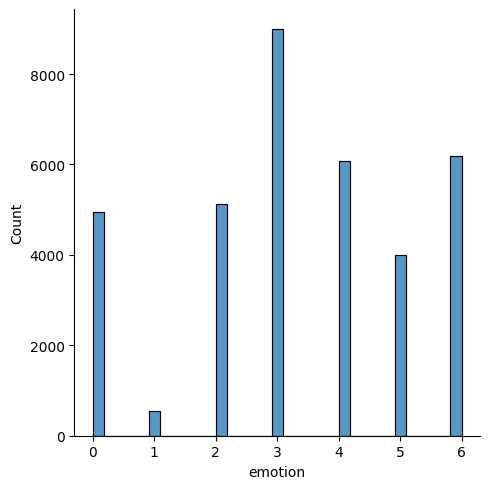

In [4]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
sns.displot(df.emotion)
plt.show()

## Data Preparation

### Convert to (m, height, width, channels) for CNN

In [99]:
X = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
X = np.stack(X, axis=0)
print(X.shape)

y = np.array(df.emotion)

(35887, 48, 48, 1)


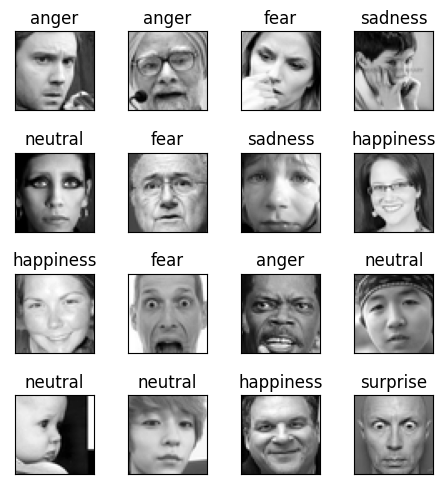

In [100]:
fig = plt.figure(1, (5, 5))
img_size = 48
for i in range(16):
    img = X[i]
    ax = plt.subplot(4,4, i+1)
    ax.imshow(img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(emotion_label_to_text[df.emotion[i]])
    plt.tight_layout()

80% Training
10% validation
10% testing

In [101]:
y

array([0, 0, 2, ..., 0, 3, 2], dtype=int64)

In [102]:
# First separate data into training set and remaining set (to be used for testing and valid)
X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, shuffle=True, train_size=0.8)

X_valid, X_test, y_valid, y_test = train_test_split(X_remaining, y_remaining, shuffle=True, test_size=0.5)


print(X_train.shape, X_valid.shape, X_test.shape, y_train.shape)

(28709, 48, 48, 1) (3589, 48, 48, 1) (3589, 48, 48, 1) (28709,)


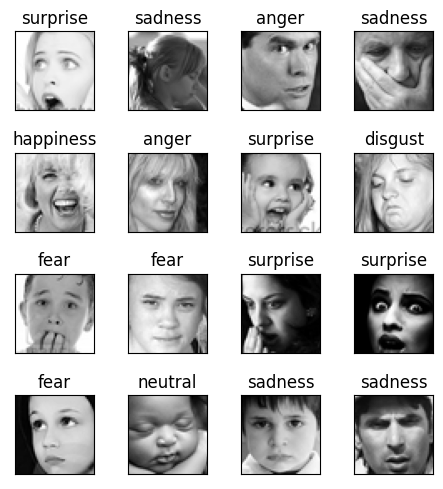

In [103]:
fig = plt.figure(1, (5, 5))
img_size = 48
for i in range(16):
    img = X_valid[i]
    ax = plt.subplot(4,4, i+1)
    ax.imshow(img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(emotion_label_to_text[y_valid[i]])
    plt.tight_layout()

## Implement batches

In [104]:
import torch
# import torchvision
# from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
import time
import os
import copy
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

In [105]:
class ImgDataset(Dataset):
    def __init__(self, X, y, transform=None, target_transform=None):
        self.X = X
        self.y = y
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.y[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [106]:
print("Done")

Done


In [107]:
train_data = ImgDataset(X_train, y_train)
valid_data = ImgDataset(X_valid, y_valid)
test_data = ImgDataset(X_test, y_test)


train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 48, 48, 1])
Labels batch shape: torch.Size([64])


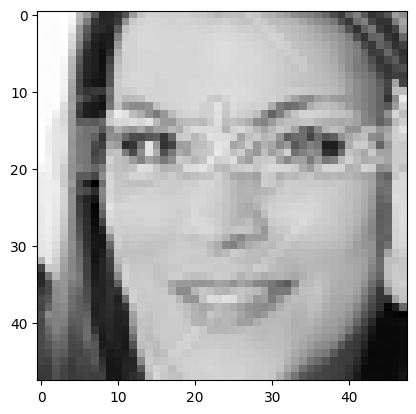

Label: happiness


In [108]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {emotion_label_to_text[label.item()]}")

## Model

In [109]:
class ConvNet(nn.Module):
    def __init__(self, num_classes: int = 10) -> None:
        super().__init__()
        self.num_classes = num_classes
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((2, 2))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(128 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [110]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using device', device)


num_classes = len(df.emotion.unique())
print("Num classes", num_classes)
criterion = nn.CrossEntropyLoss()
model = ConvNet(num_classes=num_classes).to(device)
# Use scholastic gradient descent for update weights in model with learning rate 0.001 and momentum 0.9
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


Using device cuda:0
Num classes 7


In [111]:

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, weights_name='weight_save', is_inception=False):
    since = time.time()

    val_acc_history = []
    loss_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        epoch_start = time.time()

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            
            for inputs, labels in dataloaders[phase]:
                
                inputs = inputs.permute(0,3,1,2)
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4 * loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            epoch_end = time.time()
            
            elapsed_epoch = epoch_end - epoch_start

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print("Epoch time taken: ", elapsed_epoch)

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), weights_name + ".pth")
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            if phase == 'train':
                loss_acc_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, loss_acc_history


In [112]:
dataloaders = { 'train': train_dataloader, 'val': valid_dataloader }

best_model, val_acc_history, loss_acc_history = train_model(model, dataloaders, criterion, optimizer, 10, 'convet_bestsofar')

Epoch 0/9
----------
train Loss: 1.8307 Acc: 0.2474
Epoch time taken:  8.940618991851807
val Loss: 1.8295 Acc: 0.2485
Epoch time taken:  9.288621425628662

Epoch 1/9
----------
train Loss: 1.8135 Acc: 0.2516
Epoch time taken:  8.572399616241455
val Loss: 1.7990 Acc: 0.2591
Epoch time taken:  10.845404863357544

Epoch 2/9
----------
train Loss: 1.7863 Acc: 0.2646
Epoch time taken:  17.555914402008057
val Loss: 1.7729 Acc: 0.2817
Epoch time taken:  17.964101791381836

Epoch 3/9
----------
train Loss: 1.7042 Acc: 0.3226
Epoch time taken:  14.254587888717651
val Loss: 1.6245 Acc: 0.3594
Epoch time taken:  14.618589162826538

Epoch 4/9
----------
train Loss: 1.6157 Acc: 0.3720
Epoch time taken:  14.365195035934448
val Loss: 1.5419 Acc: 0.3998
Epoch time taken:  14.806195497512817

Epoch 5/9
----------
train Loss: 1.5500 Acc: 0.4004
Epoch time taken:  15.08940601348877
val Loss: 1.5059 Acc: 0.4182
Epoch time taken:  15.44040322303772

Epoch 6/9
----------
train Loss: 1.4902 Acc: 0.4310
Epoch

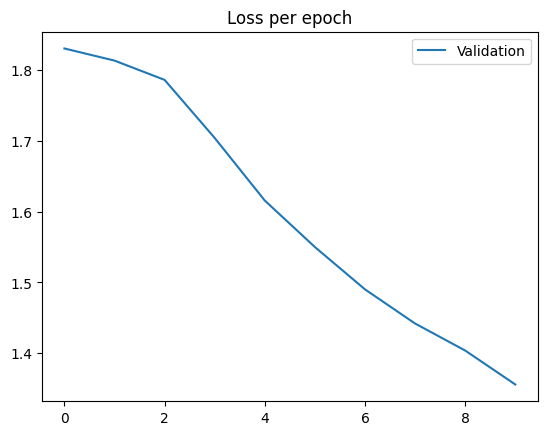

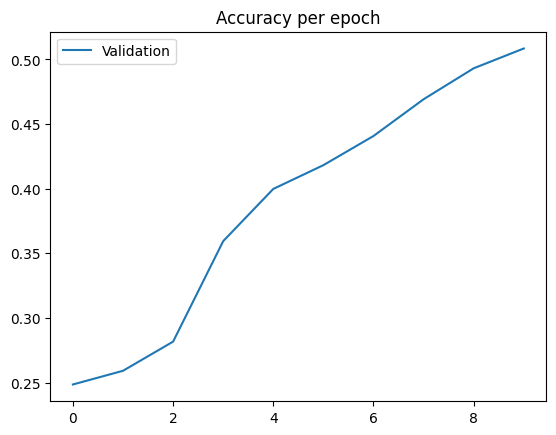

In [115]:
def plot_data(val_acc_history, loss_acc_history):
    plt.plot(loss_acc_history, label = 'Validation')
    plt.title('Loss per epoch')
    plt.legend()
    plt.show()
    plt.plot([x.cpu() for x in val_acc_history], label = 'Validation')
    plt.title('Accuracy per epoch')
    plt.legend()
    plt.show()


plot_data(val_acc_history, loss_acc_history)


tensor([4], device='cuda:0')


Text(0.5, 1.0, 'Prediction: sadness | Actual: sadness')

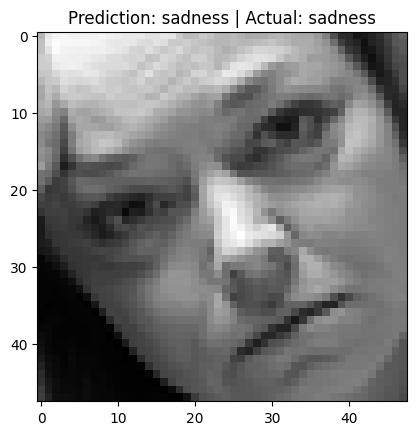

In [175]:
# Quick test

random_choice = np.random.randint(0 , X_test.shape[0]-1)
random_sample = X_test[random_choice]
x = torch.Tensor(random_sample).permute(2,0,1)
x= x[np.newaxis,:,:]
outputs = model(x.to(device))
_, preds = torch.max(outputs, 1)
print(preds)

plt.imshow(random_sample, cmap='gray')
plt.title(f"Prediction: {emotion_label_to_text[preds.item()]} | Actual: {emotion_label_to_text[y_test[random_choice]]}")

# Open Camera

In [180]:
!pip install opencv-python

In [188]:
face_haar_cascade = cv2.CascadeClassifier('data/haarcascade_frontalface_default.xml')

cap=cv2.VideoCapture(0)

while True:
    ret,test_img=cap.read()# captures frame and returns boolean value and captured image
    if not ret:
        continue
    gray_img= cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)

    faces_detected = face_haar_cascade.detectMultiScale(gray_img, 1.32, 5)


    for (x,y,w,h) in faces_detected:
        cv2.rectangle(test_img,(x,y),(x+w,y+h),(255,0,0),thickness=7)
        roi_gray=gray_img[y:y+w,x:x+h]#cropping region of interest i.e. face area from  image
        roi_gray=cv2.resize(roi_gray,(48,48))

    resized_img = cv2.resize(test_img, (1000, 700))
    cv2.imshow('Facial emotion analysis ',resized_img)



    if cv2.waitKey(10) == ord('q'):#wait until 'q' key is pressed
        break

cap.release()